# Data preprocessing

In [1]:
"""Load the data"""
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from skimage.io import imshow
from sklearn.preprocessing import OneHotEncoder

data = fetch_olivetti_faces()

In [2]:
targets = data.target
features = data.images
encoder = OneHotEncoder()
targets = encoder.fit_transform(targets.reshape(-1, 1)).todense()
xTrain, xTest, yTrain, yTest = train_test_split(features, targets, test_size=0.1)

In [3]:
"""Train set"""
print(xTrain.shape)
print(yTrain.shape)

(360, 64, 64)
(360, 40)


In [4]:
"""Test set"""
print(xTest.shape)
print(yTest.shape)

(40, 64, 64)
(40, 40)


/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


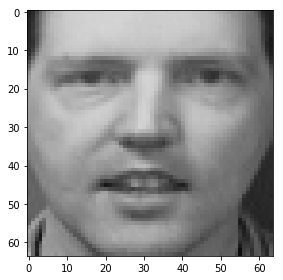

In [5]:
imshow(xTrain[0])

In [6]:
xTrainFlattened = xTrain.reshape((xTrain.shape[0], -1))
xTrainFlattened.shape

(360, 4096)

In [7]:
xTestFlattened = xTest.reshape((xTest.shape[0], -1))
xTestFlattened.shape

(40, 4096)

# Define model

In [8]:
import tensorflow as tf

init = tf.global_variables_initializer()


def logisticRegressionNetwork(inputDimension, outputDimension):
    X = tf.placeholder("float", [None, inputDimension])
    Y = tf.placeholder("float", [None, outputDimension])
    """Build Graph"""
    outputLayer = tf.nn.softmax(tf.matmul(X, tf.Variable(tf.zeros([inputDimension, 
                                        outputDimension]))) + tf.Variable(tf.zeros([outputDimension])))
    return outputLayer, X, Y

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
def trainModel(session, network, 
               xContainer, yContainer, xTrain, yTrain, xValidation, yValidation, 
               learningRate, epochs):
    
    trainSetLoss = []
    validationSetAcc = []
    trainSetAcc = []
    
    lossFunction = tf.reduce_mean(-tf.reduce_sum(yContainer * tf.log(network), reduction_indices=1))
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learningRate)
    trainOperation = optimizer.minimize(lossFunction)
    
    prediction = tf.equal(tf.argmax(network, 1), tf.argmax(yContainer, 1))
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))
    session.run(tf.global_variables_initializer())
    
    
    # Create a summary to monitor accuracy tensor
    tf.summary.scalar("Training_Accuracy", accuracy)
    tf.summary.scalar("Training_Loss", lossFunction)
    tf.summary.histogram("Acc_Hist", accuracy)
    tf.summary.histogram("Loss_Hist", lossFunction)
    merged_summary_op = tf.summary.merge_all()
    
    summary_writer = tf.summary.FileWriter("tensorboard/logs", graph=tf.get_default_graph())
    
    for i in range(0, epochs):
        _, loss, acc, summary = session.run([trainOperation, lossFunction, accuracy, merged_summary_op], feed_dict={xContainer: xTrain,
                                                                 yContainer: yTrain})
        summary_writer.add_summary(summary, i)
        if i%50 ==0:
            print("Training accuracy "+str(acc))
            
        trainSetLoss.append(loss)
        trainSetAcc.append(acc)
        loss, acc = session.run([lossFunction, accuracy], feed_dict={xContainer: xValidation,
                                                                 yContainer: yValidation})
        if i%50 ==0:
            print("Test accuracy "+str(acc))
            
        validationSetAcc.append(acc)
    return trainSetLoss, trainSetAcc, validationSetAcc

In [10]:
network, X, Y = logisticRegressionNetwork(4096, 40)
session = tf.Session()
trainSetLoss, trainSetAcc, validationSetAcc = trainModel(session, network, X, Y,
                                          xTrainFlattened, yTrain, xTestFlattened, yTest, 0.07, 300)

Training accuracy 0.022222223
Test accuracy 0.0
Training accuracy 0.65833336
Test accuracy 0.3
Training accuracy 0.90555555
Test accuracy 0.75
Training accuracy 0.975
Test accuracy 0.875
Training accuracy 0.99444443
Test accuracy 0.95
Training accuracy 1.0
Test accuracy 0.95
